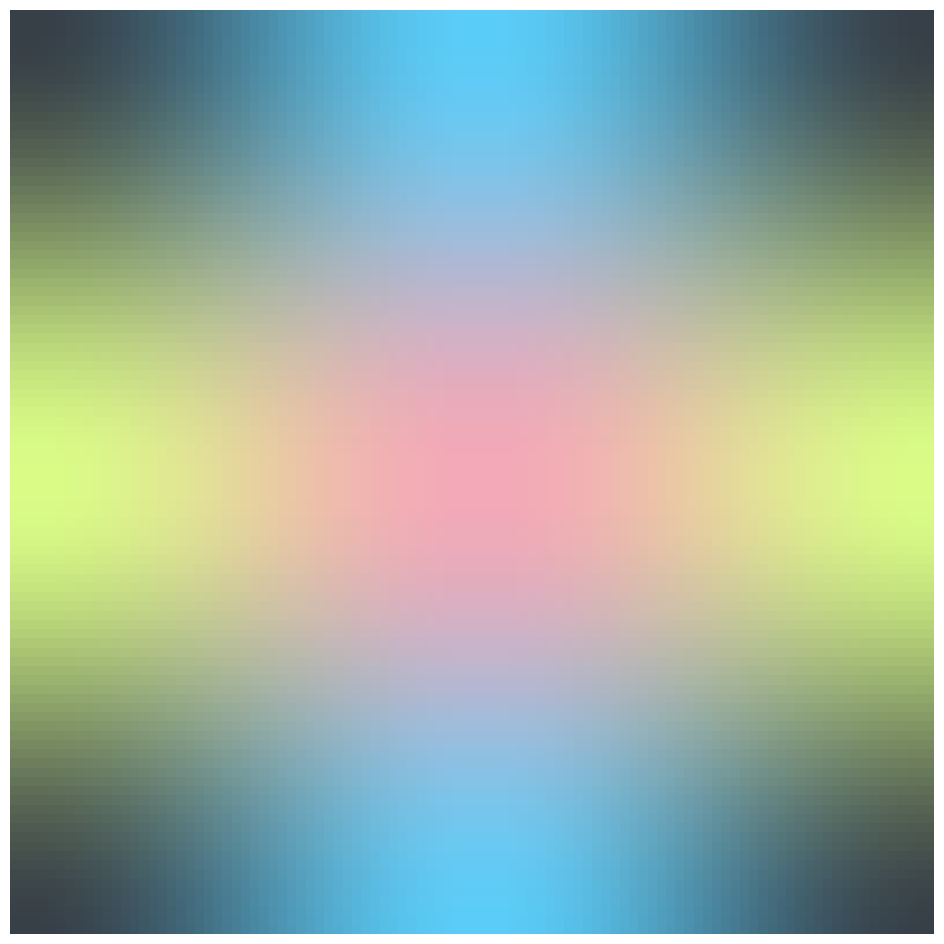

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def baseconv(input, base = 16):
    rval = input
    if isinstance(input, str):
        rval = int(input, base)
    return rval

def to_uint8(val):
    rval = val
    if val > 255:
        rval = 255
    elif val < 0:
        rval = 0
    return rval

def extract_rgb(colour):
    red = colour >> 16
    green = (colour - (red << 16)) >> 8
    blue = colour - (red << 16) - (green << 8)
    return red, green, blue

class Colour:
    def __init__(self, red = 0, green = 0, blue = 0):
        self._red = to_uint8(red)
        self._green = to_uint8(green)
        self._blue = to_uint8(blue)
    
    @classmethod
    def fromhex(cls, colour):
        r,g,b  = extract_rgb(colour)
        return cls(r, g, b)

    @property
    def red(self):
        return self._red
    
    @property
    def green(self):
        return self._green
    
    @property
    def blue(self):
        return self._blue

    def __str__(self):
        return hex(self.as_number())
    
    def __iter__(self):
        return iter((self._red, self._green, self._blue))
    
    def as_number(self):
        return (self._red << 16) + (self._green << 8) + self._blue
    
    def as_list(self):
        return np.array([self._red, self._green, self._blue])

__BLACK__ = Colour(0,0,0)


def linear(start: Colour, end : Colour, steps = 12):
    r0, g0, b0 = start
    r1, g1, b1 = end

    red   = np.linspace(r0, r1, steps, dtype=int)
    green = np.linspace(g0, g1, steps, dtype=int)
    blue  = np.linspace(b0, b1, steps, dtype=int)

    colours = [__BLACK__] * steps

    for i, (r,g,b) in enumerate(zip(red, green, blue)):
        colours[i] = Colour(r, g, b)
    
    return np.array(colours)


def chebyshev_nodes(a, b, n = 12):
    vals = np.zeros(n, dtype=int)

    for k in range(n):
        vals[k] = int(0.5*(a+b) + 0.5*(b-a) * np.cos((2*k-1)/n * np.pi))
    return vals

def chebyshev(start: Colour, end: Colour, steps = 12):
    r0, g0, b0 = start
    r1, g1, b1 = end

    red = chebyshev_nodes(r0, r1, steps)
    green = chebyshev_nodes(g0, g1, steps)
    blue = chebyshev_nodes(b0, b1, steps)

    colours = [__BLACK__] * steps

    for i, (r,g,b) in enumerate(zip(red, green, blue)):
        colours[i] = Colour(r, g, b)
    
    return np.array(colours)

class ColorgridGenerator:

    def __init__(self, **kwargs):
        self._numbase      = int(kwargs.get('base', 16))
        self._top_left     = Colour.fromhex(baseconv(kwargs.get('top_left', 0xF5A9B8), self._numbase))
        self._top_right    = Colour.fromhex(baseconv(kwargs.get('top_right', 0x5BCEFA), self._numbase))
        self._bottom_right = Colour.fromhex(baseconv(kwargs.get('bottom_right', 0x373f47), self._numbase))
        self._bottom_left  = Colour.fromhex(baseconv(kwargs.get('bottom_left', 0xDBFE87), self._numbase))
        self._ncols        = int(kwargs.get('num_cols', 12))
        self._nrows        = int(kwargs.get('num_rows', 12))

    def generate(self, sample):
        colours    = np.array([__BLACK__] * (self._ncols*self._nrows)).reshape((self._ncols, self._nrows)).T

        colours[0] = sample(self._top_left, self._top_right, self._ncols)
        colours[-1] = sample(self._bottom_left, self._bottom_right, self._ncols)
        
        for col in range(self._ncols):
            colours[:,col] = sample(colours[0, col], colours[-1, col], self._nrows)

        colours = colours.T
        grid = np.zeros((self._ncols, self._nrows, 3), dtype=int)

        for col in range(self._ncols):
            for row in range(self._nrows):
                grid[col,row] = colours[col,row].as_list()



        return grid


cols = ColorgridGenerator(num_rows=100,num_cols=100)
grid = cols.generate(chebyshev)

fig, ax = plt.subplots()
ax.axis('off')
fig.set_size_inches(12,12)
ax.imshow(grid,vmin=0, vmax=255)
plt.show()

In [3]:
cols._top_left.as_number()

16099768